## A - Importing Libraries

In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
from matplotlib import style
from  matplotlib import pylab
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
%matplotlib inline

#### Plot configuration

In [2]:
plt.rcParams["font.family"]="agency fb"
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,6)
load_model = False 

## B - Creating Agent Class

    All classes that needs to be created are created in one class.

In [3]:
class Agent():
    def __init__(self, epsilon_decay, epsilon_min, 
                       gamma, learning_rate, state_size, action_size,
                       batch_size, training_threshold):
        '''CREATING AND DEFINING BASIC PARAMETERS FOR TRAINING'''
        self.movement_penalty = -1 
        # Change epsilon if model is already trained.
        self.epsilon = 0.99                                                                     
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min                
        self.gamma = gamma
        self.learning_rate = learning_rate

        self.state_size = state_size
        self.action_size = action_size
        
        self.batch_size = batch_size
        self.training_threshold = training_threshold

         # Main Model
        self.model = self.create_model()
        
         # Target Model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
 
        self.target_update_counter = 0

        # Replay Memory
        self.replay_memory = deque(maxlen=2000) 

        if load_model:
            self.model.load_weights("../Deep Q-Learning - PACMAN/final_version_v2.h5")        
        
    
    def update_replay_memory(self, state, action, reward, next_state, done):
        '''UPDATING REPLAY MEMORY and DECAYIN EPSILON'''
        self.replay_memory.append((state, action, reward, next_state, done))

        if self.epsilon > self.epsilon_min:                                                       
            self.epsilon *= self.epsilon_decay       
    

    def create_model(self):
        '''CREATING NEURAL NETWORK'''
        model = Sequential()
        model.add(Dense(128, activation="relu", input_dim = self.state_size))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(128, activation = "relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.summary()
        model.compile(optimizer=Adam(lr=self.learning_rate), loss = "mse")          
        return model
    

    def select_action(self, state):
        '''DEFINING EPSILON GREEDY STRATEGY'''
        if np.random.rand() > self.epsilon:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
        else:
            return np.random.randint(0, self.action_size)             
 

    def train_agent(self):
        '''TRAINING AGENT'''
        if len(self.replay_memory) < self.training_threshold:
                  return
        
        batch_size = min(self.batch_size, len(self.replay_memory))
        minibatch = random.sample(self.replay_memory, batch_size)
 
        observations = np.zeros((batch_size, self.state_size))                    
        next_observations = np.zeros((batch_size, self.state_size))
        
        action = []
        reward = [] 
        done = []
        
        for sample_index in range(self.batch_size):
            observations[sample_index] = minibatch[sample_index][0]                       
            action.append(minibatch[sample_index][1])
            reward.append(minibatch[sample_index][2])
            next_observations[sample_index] = minibatch[sample_index][3]
            done.append(minibatch[sample_index][4])

            
        current_q_values = self.model.predict(observations)
        future_q_values = self.target_model.predict(next_observations)
    
        for index in range(self.batch_size):
            if not done[index]:    
                current_q_values[index][action[index]] = reward[index] + self.gamma * (np.amax(future_q_values[index]))
            else:
                current_q_values[index][action[index]] = reward[index]            

        self.model.fit(observations, current_q_values, batch_size = batch_size, verbose=0)                              
        
        if done:
            self.target_update_counter += 1
        
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

## C - Setting Hyperparameters

In [4]:
num_episodes= 2100                          
epsilon_decay = 0.999998                   
epsilon_min = 0.1                 
gamma = 0.99
learning_rate = 0.000001        
batch_size = 64
training_threshold = 1000 
update_target_every = 10
load_model = False                      

## D - Training Agent

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 50,697
Trainable params: 50,697
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               16512     
______________________________

KeyboardInterrupt: 

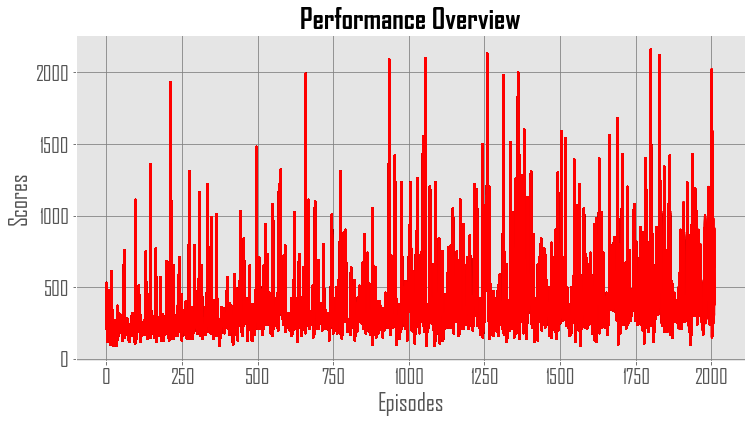

In [5]:
if __name__ == '__main__':
    
    env = gym.make('MsPacman-ram-v0')
    env.reset() 
    action_size = env.action_space.n
    state_size = env.observation_space.shape[0]
    agent = Agent(epsilon_decay, epsilon_min, 
                  gamma, learning_rate, state_size, 
                  action_size, batch_size, training_threshold)

    scores = []
    eps_plot = []
    episodes = []
    rewards_lst = []

    for episode in range(num_episodes):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])                                      
        lives = 3
        while not done:
            dead = False
            while not dead:
                #env.render()
                action = agent.select_action(state)
                
                next_state, reward, done, info = env.step(action)                       
                next_state = np.reshape(next_state, [1, state_size])                    
                
                agent.update_replay_memory(state, action, reward, next_state, done)
                agent.train_agent()
                
                state = next_state
                score += reward
                dead = info['ale.lives']<lives
                lives = info['ale.lives']
                
                if dead == True:
                    reward = -100
                else:
                    if reward ==0:
                        reward = agent.movement_penalty
                    else:
                        reward = reward
                        
            if done:
                scores.append(score)
                episodes.append(episode)
                pylab.plot(episodes, scores, 'red', linewidth=2)
                plt.xlabel("Episodes",size=24)
                plt.ylabel("Scores",size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)
                pylab.title("Performance Overview",size=28,fontweight="bold")
                plt.grid(True,color="gray")
                pylab.savefig("final_version_v2.png")
                
                print("Episode:", episode, "-----Score:", score,"-----Epsilon:", agent.epsilon)

        if (episode % 50 == 0) & (load_model==False):
            agent.model.save_weights("../Deep Q-Learning - PACMAN/final_version_v2.h5")
            print("Saved model to disk")